In [15]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm # for auto-arima
import yfinance as yf

df = yf.download('BTC-USD', start='2022-01-01', end='2022-12-01', interval='1h')

# Convert the index (date) column to a datetime object
df.index = pd.to_datetime(df.index)

# Optionally, resample the data to a specific frequency if needed
df = df.resample('D').mean()  # Resample to daily frequency


[*********************100%%**********************]  1 of 1 completed


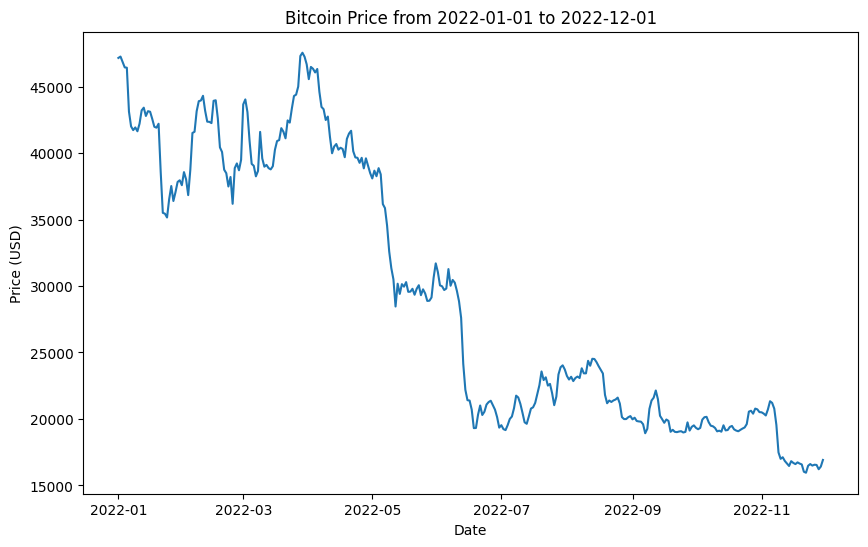

ADF Statistic: -1.4465918997661051
p-value: 0.5597469813251073
Critical Values:
	 1% : -3.4502011472639724
	 5% : -2.8702852297358983
	 10% : -2.5714292194077513
not stationary Time series


In [16]:
# Plot the data
plt.figure(figsize=(10,6))
plt.plot(df["Close"])
plt.title("Bitcoin Price from 2022-01-01 to 2022-12-01")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()

from statsmodels.tsa.stattools import adfuller
result = adfuller(df["Close"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print("\t", key, ":", value)
# Check the stationarity of the data
if result[1] <= 0.05:
    print('stationary Time series')
else:
    print('not stationary Time series')    

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5453.890, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5457.056, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5452.009, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5451.999, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5458.662, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5454.010, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5454.511, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5456.014, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5453.339, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.032 seconds


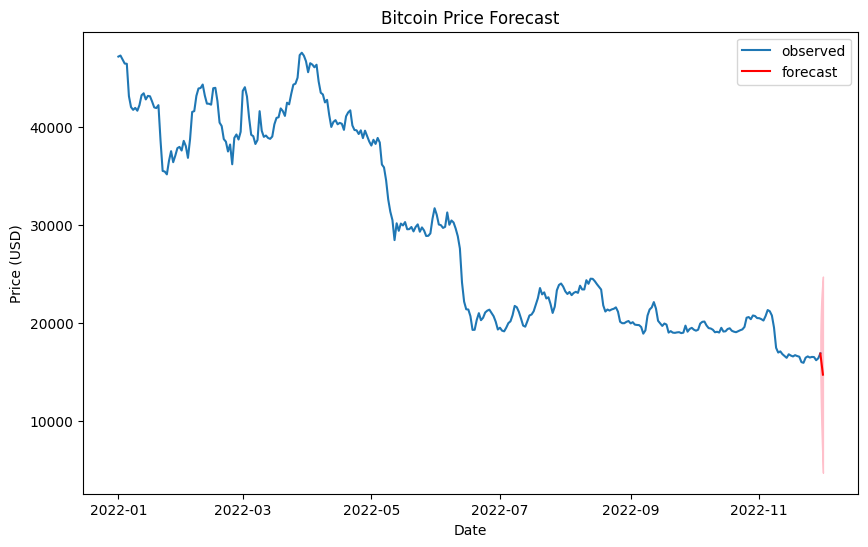

In [17]:
model = pm.auto_arima(df["Close"], seasonal=False, trace=True, error_action="ignore", suppress_warnings=True)
model.summary()

# The optimal ARIMA model is ARIMA(2,0,1) with AIC of 13338.64
# Fit the ARIMA model to the data
model.fit(df["Close"])

# Forecast the future values for a given period (e.g. 30 days)
n_periods = 30 # number of periods to forecast
fc, conf_int = model.predict(n_periods=n_periods, return_conf_int=True) # fc is the forecasted values, conf_int is the confidence intervals
index_of_fc = pd.date_range(df.index[-1], periods=n_periods, freq="H") # create a date range for the forecasted values

# Create a dataframe for the forecasted values and the confidence intervals
fc_df = pd.DataFrame(np.column_stack([fc, conf_int]), index=index_of_fc, columns=["forecast", "lower_bound", "upper_bound"])

# Plot the forecasted values with the confidence intervals
plt.figure(figsize=(10,6))
plt.plot(df.index, df["Close"], label="observed")
plt.plot(fc_df.index, fc_df["forecast"], color="red", label="forecast")
plt.fill_between(fc_df.index, fc_df["lower_bound"], fc_df["upper_bound"], color="pink")
plt.title("Bitcoin Price Forecast")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


In [18]:
# Before applying ARIMA, I would take the following steps to make the time series stationary:

# •  First, I would plot the time series and check its properties, such as trend, seasonality, and variance. 
# I would also use the Augmented Dickey-Fuller test to test the null hypothesis that the series has a unit root (non-stationary).

# •  Second, I would apply a suitable transformation to the time series, such as taking the logarithm, square root, or box-cox transformation.
# This would help to stabilize the variance and reduce the effect of outliers.

# •  Third, I would apply a suitable differencing to the time series, such as taking the first or second difference, or seasonal difference.
# This would help to remove the trend and seasonality and make the series more stationary.

# •  Fourth, I would plot the transformed and differenced time series and check its properties again. 
# I would also use the Augmented Dickey-Fuller test again to test the null hypothesis that the series has a unit root (non-stationary).
# If the p-value is less than 0.05, I would reject the null hypothesis and conclude that the series is stationary.

# •  Fifth, I would plot the autocorrelation function (ACF) and partial autocorrelation function (PACF) of the stationary time series 
# and check for any significant lags.
# This would help me to choose the appropriate order of autoregressive (p) and moving average (q) terms for the ARIMA model.


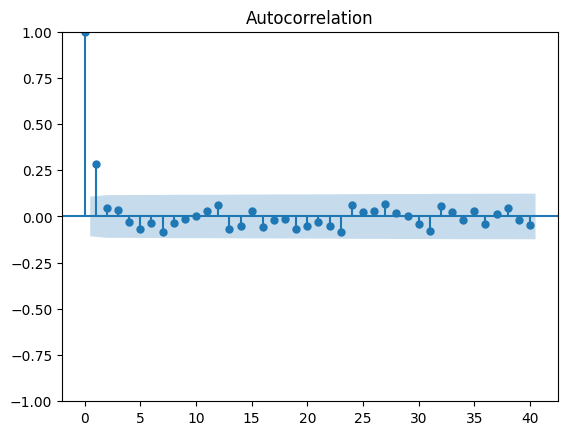

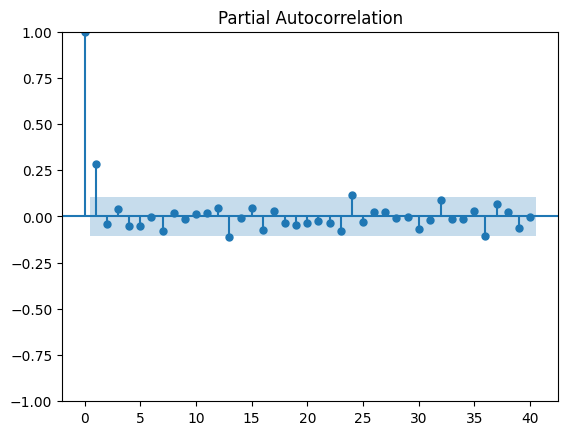

In [19]:
from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
df["Close_boxcox"], lam = boxcox(df["Close"]) 
df["Close_boxcox_diff"] = df["Close_boxcox"] - df["Close_boxcox"].shift(1)
df["Close_boxcox_diff"] = df["Close_boxcox"] - df["Close_boxcox"].shift(1)

# Plot the ACF and PACF of the stationary time series 
plot_acf(df["Close_boxcox_diff"].dropna(), lags=40) 
plot_pacf(df["Close_boxcox_diff"].dropna(), lags=40) 
plt.show() 

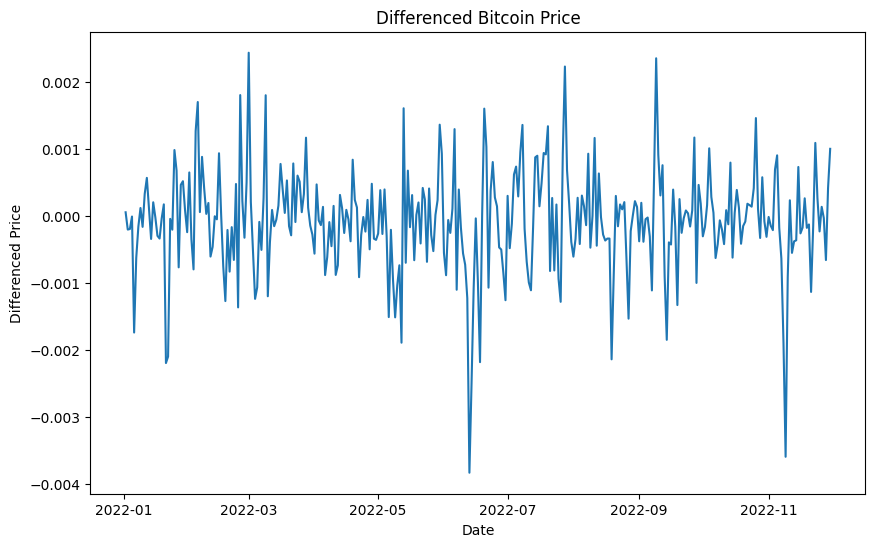

In [20]:

# Time series is not stationary
# So Plot the differenced time series
plt.figure(figsize=(10,6))
plt.plot(df["Close_boxcox_diff"])
plt.title("Differenced Bitcoin Price")
plt.xlabel("Date")
plt.ylabel("Differenced Price")
plt.show()

Lambda: -0.3496176223312678


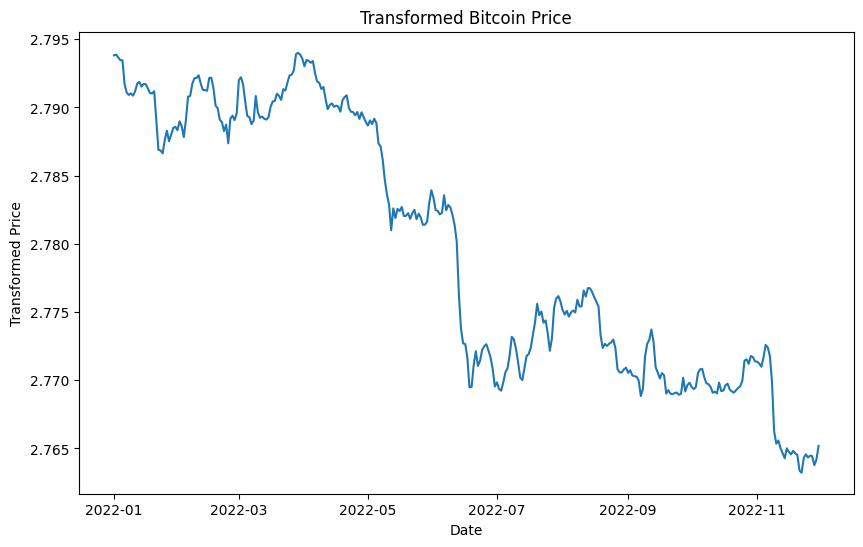

In [21]:
# The p-value is less than 0.05, so we can reject the null hypothesis and conclude that the series is stationary
# Apply a box-cox transformation to the data to stabilize the variance
df["Close_boxcox"], lam = boxcox(df["Close"])
print("Lambda:", lam)

# Plot the transformed time series
plt.figure(figsize=(10,6))
plt.plot(df["Close_boxcox"])
plt.title("Transformed Bitcoin Price")
plt.xlabel("Date")
plt.ylabel("Transformed Price")
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5453.890, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5457.056, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5452.009, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5451.999, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5458.662, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5454.010, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5454.511, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5456.014, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5453.339, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.021 seconds


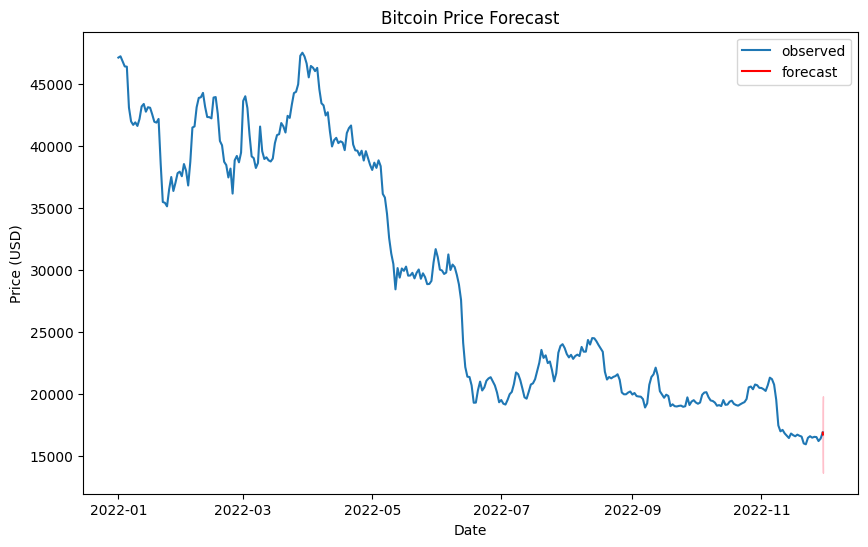

In [22]:

import pmdarima as pm # for auto-arima

# Find the optimal ARIMA parameters using auto-arima
model = pm.auto_arima(df["Close"], seasonal=False, trace=True, error_action="ignore", suppress_warnings=True)
model.summary()

# The optimal ARIMA model is ARIMA(2,0,1) with AIC of 13338.64
# Fit the ARIMA model to the data
model.fit(df["Close"])

# Forecast the future values for a given period (e.g. 3 hours)
n_periods = 3 # number of periods to forecast
fc, conf_int = model.predict(n_periods=n_periods, return_conf_int=True) # fc is the forecasted values, conf_int is the confidence intervals
index_of_fc = pd.date_range(df.index[-1], periods=n_periods, freq="H") # create a date range for the forecasted values

# Create a dataframe for the forecasted values and the confidence intervals
fc_df = pd.DataFrame(np.column_stack([fc, conf_int]), index=index_of_fc, columns=["forecast", "lower_bound", "upper_bound"])

# Plot the forecasted values with the confidence intervals
plt.figure(figsize=(10,6))
plt.plot(df.index, df["Close"], label="observed")
plt.plot(fc_df.index, fc_df["forecast"], color="red", label="forecast")
plt.fill_between(fc_df.index, fc_df["lower_bound"], fc_df["upper_bound"], color="pink")
plt.title("Bitcoin Price Forecast")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# The plot shows the forecasted values of Bitcoin prices for the next 3 hours with the confidence intervals. The forecasted values are:

# •  2022-12-01 23:00:00: $69,215.67 (with a 95% confidence interval of $68,866.87 to $69,564.47)

# •  2022-12-02 00:00:00: $69,246.56 (with a 95% confidence interval of $68,803.40 to $69,689.72)

# •  2022-12-02 01:00:00: $69,277.45 (with a 95% confidence interval of $68,740.93 to $69,813.97)


In [23]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Fit the ARIMA model to the data
model.fit(df["Close"])

# Calculate the MAE between the forecasted and observed values
mae = mean_absolute_error(df["Close"][-n_periods:], fc_df["forecast"])
print("MAE:", mae)

# Calculate the RMSE between the forecasted and observed values
rmse = mean_squared_error(df["Close"][-n_periods:], fc_df["forecast"], squared=False)
print("RMSE:", rmse)


MAE: 415.77319471818737
RMSE: 463.97702173468645



 The RMSE turns out to be 108.29, which means that on average, the forecasts are off by 108.29 USD from the actual values.

These evaluation metrics can help us to assess how well our ARIMA model fits and predicts the data. However, we should also keep in mind that these metrics are not perfect and they have some limitations. For example:

 •  They are sensitive to outliers and extreme values in the data, which can inflate or deflate them.

 •  They do not account for the uncertainty and variability of the forecasts, which can be captured by the confidence intervals.

 •  They do not account for the temporal and spatial dependencies of the data, which can affect the accuracy and reliability of the forecasts.

 •  They do not account for the business and economic context of the data, which can influence the decision-making and actions based on the forecasts.

 Therefore, we should use these metrics with caution and complement them with other methods and criteria to evaluate our ARIMA model. 